In [16]:
import pdftotext
import pandas as pd
import numpy as np
import re
import os

#%% # snetiment analysis
import numpy as np
import pandas as pd

import re
import string 

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

import nltk 
nltk.download('twitter_samples')
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords          # module for stop words that come with NLTK
nltk.download('stopwords')
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Define function for "Cleaning" and "participants list"

In [17]:
def cleaning_text(contents):
    # change the text input to df
    df = pd.DataFrame(contents)
    # remove the unnessary string
    df[0] = df[0].str.replace('\n','')
    df[0] = df[0].str.replace('Bloomberg Transcript','')
    df[0] = df[0].str.replace('\x0c\n','')
    df[0] = df[0].str.replace('FINAL','')
    df[0] = df[0].str.replace('A - ','')
    df[0] = df[0].str.replace('Q - ','')
    # using re to remove the unnessary string
    def drop_unnessary(x):
        page = re.findall(r'Page \d+ of \d+', x) # 'page ... of ... '
        BIO = re.findall(r'{BIO', x) # '{BIO 18731996 <GO>}'
        Company_Name = re.findall(r'Company N ame:', x) # 'Company N ame: H annover Rueck SE'
        Company_Ticker = re.findall(r'Company Ticker:', x) # 'Company Ticker: H N R1 GR Equity'
        Date = re.findall(r'Date:', x) # Date: 2015-03-10
        if page == [] and BIO == [] and Company_Name == [] and Company_Ticker == [] and Date == []:
            return True
        else:
            return False

    true_false = df[0].apply(lambda x: drop_unnessary(x))
    df = df[true_false]

    # drop the final page declaration
    df = df[df[0] != 'This transcript may not be 100 percent accurate and may contain misspellings and other']
    df = df[df[0] != 'inaccuracies. This transcript is provided "as is", without express or implied warranties of']
    df = df[df[0] != 'any kind. Bloomberg retains all rights to this transcript and provides it solely for your']
    df = df[df[0] != 'personal, non-commercial use. Bloomberg, its suppliers and third-party agents shall']
    df = df[df[0] != 'have no liability for errors in this transcript or for lost profits, losses, or direct, indirect,']
    df = df[df[0] != 'incidental, consequential, special or punitive damages in connection with the']
    df = df[df[0] != 'furnishing, performance or use of such transcript. Neither the information nor any']
    df = df[df[0] != 'opinion expressed in this transcript constitutes a solicitation of the purchase or sale of']
    df = df[df[0] != 'securities or commodities. Any opinion expressed in the transcript does not necessarily']
    # df = df[df[0] != 'reflect the views of Bloomberg LP. ¬© COPYRIGHT 2022, BLOOMBERG LP. All rights']  # we will need this to identify the last participant
    df = df[df[0] != 'reserved. Any reproduction, redistribution or retransmission is expressly prohibited.']
    # ¬© could not be identified, would apply re
    def drop_Bloomberg_mark(x):
        Bloomberg_mark = re.findall(r'reflect the views of Bloomberg LP', x) # 'reflect the views of Bloomberg LP. ¬© COPYRIGHT 2022, BLOOMBERG LP. All rights'
        if Bloomberg_mark == []:
            return True
        else:
            return False

    true_false = df[0].apply(lambda x: drop_Bloomberg_mark(x))
    df = df[true_false]

    # drop the empthy row
    df = df[df[0] != '']
    df = df[df[0] != '']

    return df

def participants_list(df):
    # reset the index to make sure the index is continuous for better processing
    df = df.reset_index(drop=True)
    #  'Company Participants' index
    Participant_start_index = df.index[df.iloc[:,0] == 'Company Participants'].tolist()
    #  'Other Participants' index
    Participant_middle_index = df.index[df.iloc[:,0] == 'Other Participants'].tolist()
    #  'MANAGEMENT DISCUSSION SECTION' index, is the beginning of the management discussion, would stop before this row
    Participant_end_index = df.index[df.iloc[:,0] == 'MANAGEMENT DISCUSSION SECTION' ].tolist()
    # try to find the 'MANAGEMENT DISCUSSION SECTION' or 'Presentation' index
    if Participant_end_index == []:
        Participant_end_index = df.index[df.iloc[:,0] == 'Presentation'].tolist()
        Participant_end_index = [Participant_end_index[-1]]
    # some transcript dont have 'Other Participants'
    if Participant_middle_index == []:
        Participant_middle_index = Participant_end_index
    print(Participant_start_index, Participant_middle_index, Participant_end_index)

    # make the list of company_paticipants 
    company_paticipants = df.loc[Participant_start_index[0]+1:Participant_middle_index[0]-1]
    company_paticipants.drop(company_paticipants.index[company_paticipants.iloc[:,0] == ''].tolist(), inplace=True)
    company_paticipants = company_paticipants.values.tolist()
    # and other_participants
    other_paticipants = df.loc[Participant_middle_index[0]+1:Participant_end_index[0]-1]
    other_paticipants.drop(other_paticipants.index[other_paticipants.iloc[:,0] == ''].tolist(), inplace=True)
    other_paticipants = other_paticipants.values.tolist()

    # after extract the paticipants, we can drop those information to make the transcript more clear
    df = df.reset_index(drop=True)
    df = df.drop(range(df.index[df.iloc[:,0] == 'Company Participants'].tolist()[0],df.index[df.iloc[:,0].isin(['MANAGEMENT DISCUSSION SECTION','Presentation'])].tolist()[0]+1))
    # drop the first row of the df
    df = df.reset_index(drop=True)
    df = df.iloc[1: , :]
    # reset the index again to make sure the index is continuous for better processing
    df = df.reset_index(drop=True)
    # # save to csv
    # df.to_csv('/Users/timliu/Desktop/output/df.csv')
    return df, company_paticipants, other_paticipants

In [18]:
# ### Testing on the single company
# path = "/Users/timliu/Documents/GitHub/data_collecting/BBG_original_file/European (Re)Insurers/HNR1 GY" #資料夾目錄
# save_path = "/Users/timliu/Documents/GitHub/data_collecting/output/HNR1 GY_text"

path = "/Users/timliu/Documents/GitHub/final_01/Transcript_test"
save_path = "/Users/timliu/Documents/GitHub/final_01/Output"

In [19]:
# df = pd.DataFrame()
# # create a dataframe with 2500 rows (to make sure all the paragraphs are including)
# df_clean_na = pd.DataFrame(np.zeros((2500,1)), columns=['index'])
# all_participants = []
# company_paticipants_list = []
# other_paticipants_list = []

# files= os.listdir(path) #得到資料夾下的所有檔名稱
# for file in files:
#     if file.endswith(".pdf"):
#         # print(file)
#         # Load PDF
#         with open(path+"/"+file, "rb") as f:
#             pdf = pdftotext.PDF(f)
#         # Save all text to a txt file.
#         with open(save_path+"/"+file.replace(".pdf", ".txt"), "w") as f:
#             f.write("\n\n".join(pdf))
#         # open the text file
#         with open(save_path+"/"+file.replace(".pdf", ".txt")) as f:
#             contents = f.readlines()
#             df_clean = cleaning_text(contents)
#             # extract all the participants
#             df_pure_text,company_paticipants,other_paticipants = participants_list(df_clean)
#             all_participants.append(company_paticipants)
#             company_paticipants_list.append(other_paticipants)
#             other_paticipants_list.append(company_paticipants)
#             # using the file name to set as the dataframe's column name
#             # df[f"{files.index(file)}"] = df_clean
#             df[f"{files[files.index(file)]}"] = df_pure_text
#             df_clean_na[f"{files[files.index(file)]}"] = df[f"{files[files.index(file)]}"].dropna(inplace=False).reset_index(drop=True)

# # drop the first column of the df
# df_clean_na = df_clean_na.iloc[:,1:]
# df_clean_na

In [20]:
# all files path
company_paths = []
sectors = os.listdir(path) 
for sector in sectors:
    # path to each sector files
    if sector != '.DS_Store':
        sector_path = path+"/"+sector
    
    # path to each company files
    companies = os.listdir(sector_path) 
    print(companies)
    for company in companies:
        if company != '.DS_Store':
            company_path = sector_path+"/"+company
            company_paths.append(company_path)

['8630 JT', '8725 JT', '.DS_Store', 'QBE AU', '8766 JT']
['8630 JT', '8725 JT', '.DS_Store', 'QBE AU', '8766 JT']
['SREN SE', '.DS_Store', 'SCR FP', 'HNR1 GY', 'MUV2 GY']


In [21]:
# all files path
company_paths = []
sectors = os.listdir(path) 
for sector in sectors:
    # path to each sector files
    if sector != '.DS_Store':
        sector_path = path+"/"+sector
    
    # path to each company files
    companies = os.listdir(sector_path) 
    #print(companies)
    for company in companies:
        if company != '.DS_Store':
            company_path = sector_path+"/"+company
            company_paths.append(company_path)

# create dataframe
df = pd.DataFrame()
df_clean_na = pd.DataFrame(np.zeros((2500,1)), columns=['index']) # create a dataframe with 2500 rows
all_participants = []      
company_paticipants_list = []
other_paticipants_list = []

for single_path in company_paths:
    files = os.listdir(single_path)
    for file in files:
        print(file)
        if file.endswith(".pdf"):
            # print(file)
            # Load PDF
            with open(single_path+"/"+file, "rb") as f:
                pdf = pdftotext.PDF(f)
            # Save all text to a txt file.
            with open(save_path+"/"+file.replace(".pdf", ".txt"), "w") as f:
                f.write("\n\n".join(pdf))
            # open the text file
            with open(save_path+"/"+file.replace(".pdf", ".txt")) as f:
                contents = f.readlines()
                df_clean = cleaning_text(contents)
                # extract all the participants
                df_pure_text,company_paticipants,other_paticipants = participants_list(df_clean)
                all_participants.append(company_paticipants)
                all_participants.append(other_paticipants)
                # using the file name to set as the dataframe's column name
                # df[f"{files.index(file)}"] = df_clean
                df[f"{files[files.index(file)]}"] = df_pure_text
                df_clean_na[f"{files[files.index(file)]}"] = df[f"{files[files.index(file)]}"].dropna(inplace=False).reset_index(drop=True)

# drop the first column of the df
df_clean_na = df_clean_na.iloc[:,1:]
df_clean_na.head(5)

20121119_Sompo_Holdings_Inc-_Earnings_Call_2012-11-20_RT000000002067692926.pdf
[1] [4] [12]
20191128_Sompo_Holdings_Inc-_Conf-Presentation_Call_2019-11-28_SD000000002903087817.pdf


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[2] [8] [15]
20180524_Sompo_Holdings_Inc-_M-A_Call_2018-5-24_FS000000002476688929.pdf
[1] [3] [10]
20190520_Sompo_Holdings_Inc-_Earnings_Call_2019-5-20_SD000000002902929962.pdf
[1] [4] [11]
20120518_Sompo_Holdings_Inc-_Earnings_Call_2012-5-21_RT000000002050742732.pdf
[1] [4] [14]
20141119_Sompo_Holdings_Inc-_Earnings_Call_2014-11-24_FS000000002417374854.pdf
[1] [4] [11]
20151118_Sompo_Holdings_Inc-_Earnings_Call_2015-11-20_DN000000002241138647.pdf
[1] [3] [12]
20131119_Sompo_Holdings_Inc-_Earnings_Call_2013-11-25_DN000000002116348219.pdf
[1] [3] [10]
.DS_Store
20181119_Sompo_Holdings_Inc-_Earnings_Call_2018-11-19_SD000000002905610039.pdf
[1] [4] [12]
20151126_Sompo_Holdings_Inc-_Conf-Presentation_Call_2015-11-26_SD000000002889371132.pdf
[1] [4] [12]
20190528_Sompo_Holdings_Inc-_Conf-Presentation_Call_2019-5-28_SD000000002902938862.pdf
[2] [8] [16]
20150520_Sompo_Holdings_Inc-_Earnings_Call_2015-5-21_DN000000002212245169.pdf
[1] [3] [11]
20161005_Sompo_Holdings_Inc-_M-A_Call_2016-10-5_F

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_35307/4065511328.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean_na[f"{files[files.index(file)]}"] = df[f"{files[files.index(file)]}"].dropna(inplace=False).reset_index(drop=True)
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_35307/4065511328.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{files[files.index(file)]}"] = df_pure_text


[2] [9] [17]
20130213_TOKIO_MARINE_HD-_Earnings_Call_2013-2-13_DN000000002077439881.pdf
[1] [3] [8]
20150520_TOKIO_MARINE_HD-_Earnings_Call_2015-5-20_DN000000002212037068.pdf
[1] [3] [3]
20170519_TOKIO_MARINE_HD-_Earnings_Call_2017-5-19_FS000000002351735615.pdf
[1] [4] [11]
20191003_TOKIO_MARINE_HD-_M-A_Call_2019-10-3_SD000000002888014841.pdf
[2] [4] [4]
20190527_TOKIO_MARINE_HD-_Conf-Presentation_Call_2019-5-27_SD000000002902936847.pdf
[1] [11] [19]
20180214_TOKIO_MARINE_HD-_Earnings_Call_2018-2-14_FS000000002400295131.pdf
[1] [3] [7]
20131119_TOKIO_MARINE_HD-_Earnings_Call_2013-11-20_DN000000002115755239.pdf
[1] [5] [9]
20130809_TOKIO_MARINE_HD-_Earnings_Call_2013-8-12_DN000000002102494109.pdf
[1] [4] [11]
20200520_TOKIO_MARINE_HD-_Earnings_Call_2020-5-20_RT000000002841939564.pdf
[1] [3] [3]
20160520_TOKIO_MARINE_HD-_Earnings_Call_2016-5-20_FS000000002279195483.pdf
[1] [3] [10]
20171117_TOKIO_MARINE_HD-_Earnings_Call_2017-11-17_FS000000002455656984.pdf
[1] [3] [10]
20170214_TOKIO_MAR

,20121119_Sompo_Holdings_Inc-_Earnings_Call_2012-11-20_RT000000002067692926.pdf,20191128_Sompo_Holdings_Inc-_Conf-Presentation_Call_2019-11-28_SD000000002903087817.pdf,20180524_Sompo_Holdings_Inc-_M-A_Call_2018-5-24_FS000000002476688929.pdf,20190520_Sompo_Holdings_Inc-_Earnings_Call_2019-5-20_SD000000002902929962.pdf,20120518_Sompo_Holdings_Inc-_Earnings_Call_2012-5-21_RT000000002050742732.pdf,20141119_Sompo_Holdings_Inc-_Earnings_Call_2014-11-24_FS000000002417374854.pdf,20151118_Sompo_Holdings_Inc-_Earnings_Call_2015-11-20_DN000000002241138647.pdf,20131119_Sompo_Holdings_Inc-_Earnings_Call_2013-11-25_DN000000002116348219.pdf,20181119_Sompo_Holdings_Inc-_Earnings_Call_2018-11-19_SD000000002905610039.pdf,20151126_Sompo_Holdings_Inc-_Conf-Presentation_Call_2015-11-26_SD000000002889371132.pdf,...,20210810_Munich_Re-_Earnings_Call_2021-8-10_DN000000002962247258.pdf,20201208_Munich_Re-_Shareholder_Mtg_Call_2020-12-8_DN000000002944723654.pdf,20200507_Munich_Re-_Earnings_Call_2020-5-7_RT000000002834670399.pdf,20171109_Munich_Re-_Earnings_Call_2017-11-9_FS000000002383615110.pdf,20170509_Munich_Re-_Earnings_Call_2017-5-9_FS000000002450443745.pdf,20170315_Munich_Re-_Earnings_Call_2017-3-15_FS000000002336461963.pdf,20151105_Munich_Re-_Earnings_Call_2015-11-5_FS000000002238544235.pdf,20171121_Munich_Re-_Shareholder_Mtg_Call_2017-11-21_SD000000002905542974.pdf,20190320_Munich_Re-_Earnings_Call_2019-3-27_RT000000002898185222.pdf,20150806_Munich_Re-_Earnings_Call_2015-8-6_SD000000002845566471.pdf
0,Shinichi Hara,Presentation,Unverified Participant,Osamu Nose,Shinichi Hara,Yukinori Kuroda,Yukinori Kuroda,Shinichi Hara,Yukinori Kuroda,Kengo Sakurada,...,Operator,Christian Becker-Hussong,Operator,Christian Becker-Hussong,Operator,Christian Becker-Hussong,Operator,Muenchen Investor Day,Christian Becker-Hussong,Joerg Schneider
1,I am Hara from NKSJ Holdings. Thank you very m...,Company Participants,I thank all of you for gathering here today fo...,"Hello. I am Osamu Nose, Head of Investor Relat...",Good evening. This is Shinichi Hara of NKSJ Ho...,"Hello, everyone. I'm Kuroda of Investor Relati...",So this is Kuroda from Sompo Japan Nipponkoa H...,I'm Hara from NK Share Holdings. Thank you ver...,I'm Kuroda with Sompo Holdings. Thank you very...,"As introduced, I am Sakurada, the Group CEO. F...",...,"Good day, and welcome to the Munich Re Half Ye...","Good afternoon, ladies and gentlemen and warm ...","Good day, and welcome to the Muenchener Quarte...",Thanks for joining us for our Q3 earnings call...,"Good day, ladies and gentlemen, and welcome to...","Ladies and gentlemen, welcome to the Munich Re...","Good day, ladies and gentlemen. Welcome to the...",Christian Becker-Hussong,Thank you. Ladies and gentlemen a warm welcome...,"Ladies and gentlemen, welcome to the presentat..."
2,sure you're tired by now at this late hour but...,"Kengo Sakurada, President, Group CEO, Chairman...",are as we have announced on the 18th. Therefor...,Holdings. Thank you for participating in our c...,busy schedule to attend this conference call. ...,Thank you very much for joining us today in th...,participating in today's conference call.,"call for the first half results. Today, I'll c...",schedule to this conference call. I would like...,meeting despite your busy schedule. It seems t...,...,Conference Call. Today's conference is being r...,Investor Day on Munich Re Group's Ambition 202...,Results Conference Call. Today's conference is...,"very straightforward, after my short introduct...",Q1 Conference Call. Today's conference is bein...,room. And of course also a very warm welcome t...,Statement Conference Call. Today's conference ...,"Good morning, everyone. Welcome to our Investo...",Financial Results 2018 and Strategic Outlook. ...,Schneider and I am the CFO of Munich Re Group.
3,What I am going to explain today is only the f...,"Masahiro Hamada, Group CFO, Group CIO, Executi...","for myself today, I will be mainly talking abo...",I would like to go through our

In [22]:
def clean_participants_list(def_participants):
    # get the value inside the def_participants 
    def_participants = [item for sublist in def_participants for item in sublist]
    def_participants = [i[0] for i in def_participants]
    # print(def_participants)
    # %%
    # exclude the title of the participants, i.e.'Roland Vogel, CFO' to 'Roland Vogel" by using re
    def_participants = [re.sub(r'\,.*', '', participant) for participant in def_participants]
    # exclude the 'Property & Casualty Reinsurance'
    def_participants = [re.sub(r'Property & Casualty Reinsurance', '', participant) for participant in def_participants]
    # exclude the '[0682QB-E Ulrich Wallin]'
    def_participants = [re.sub(r'\[0682QB-E Ulrich Wallin\]', '', participant) for participant in def_participants]
    # drop duplicated participants
    # def_participants = [i[0] for i in def_participants]
    # drop the empty string
    def_participants = [participant for participant in def_participants if participant != '']
    # remove the sapce in the string
    def_participants = [participant.strip() for participant in def_participants]
    # add the 'Operator' to the list
    def_participants.append('Operator')

    # drop the duplicated participants
    def_participants_copy = def_participants.copy()
    def_participants = []
    # drop the duplicated participants
    for i in def_participants_copy: 
        if i not in def_participants: 
            def_participants.append(i) 
    def_participants = sorted(def_participants)
    
    return def_participants

all_participants = clean_participants_list(all_participants)
company_paticipants_list = clean_participants_list(company_paticipants_list)
other_paticipants_list = clean_participants_list(other_paticipants_list)


In [23]:
concat_df = pd.DataFrame()
for column in df_clean_na.columns:
    # identify all the rows in df with all_participants in it
    both_participants_row_index = df_clean_na[df_clean_na[column].isin(all_participants)].index.tolist()
    # apply the both_participants_row_index to the df_clean_na['participants']
    concat_df[column] = df_clean_na[column]
    concat_df[f"participants_{column}"] = df_clean_na[column].apply(lambda x: x if x in all_participants else np.nan)
    # fill the NaN with the value of the previous row
    concat_df[f"participants_{column}"] = concat_df[f"participants_{column}"].fillna(method='ffill')

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_35307/3664898758.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_df[column] = df_clean_na[column]
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_35307/3664898758.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_df[f"participants_{column}"] = df_clean_na[column].apply(lambda x: x if x in all_participants else np.nan)


In [25]:
no_par_df = pd.DataFrame()
# identify the len before NaN of each column
for column in df_clean_na.columns:
    # exclude the row if no_par_df[column]==no_par_df[f"participants_{column}"]
    no_par_df = concat_df[concat_df[column] != concat_df[f"participants_{column}"]]

# use len(no_par_df.columns.to_list()) to write a for loop
model_df = pd.DataFrame()
for i in range(int(len(no_par_df.columns.to_list())/2)):
    tmp_df = pd.DataFrame()
    tmp_df = no_par_df.iloc[:,(i*2):(i*2)+2]
    # extract the index as column from the text
    tmp_df['file_name'] = tmp_df.columns.to_list()[0]
    # extract the date from the index column
    tmp_df['date'] = tmp_df['file_name'].apply(lambda x: x.split('_')[0])
    # change the date column to datetime
    tmp_df['date'] = pd.to_datetime(tmp_df['date'])
    # rename to be consistent with the column name
    tmp_df.columns = ["paragraph", "participants", "file_name","date"]
    # if the 'participants' column's value equals to any of the company_paticipants_list, other_paticipants_list, then set the value to 0
    tmp_df['company_paticipants_yes'] = tmp_df['participants'].apply(lambda x: 1 if x in company_paticipants_list else 0)
    tmp_df['other_paticipants_yes'] = tmp_df['participants'].apply(lambda x: 1 if x in other_paticipants_list else 0)
    # drop the row if the column "paragraph" is NaN
    tmp_df = tmp_df.dropna(subset=['paragraph'], how='all')
    tmp_df['company_name1']  = tmp_df['file_name'].apply(lambda x: x.split('_')[1])
    tmp_df['company_name2']  = tmp_df['file_name'].apply(lambda x: x.split('_')[2])
    tmp_df['company_name'] = tmp_df["company_name1"] + " " + tmp_df["company_name2"]
    # drop the 'company_name1' and 'company_name2' column
    tmp_df = tmp_df.drop(columns=['company_name1', 'company_name2'])
    model_df = model_df.append(tmp_df)

model_df

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_35307/2318456439.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['file_name'] = tmp_df.columns.to_list()[0]
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_35307/2318456439.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['date'] = tmp_df['file_name'].apply(lambda x: x.split('_')[0])
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_35307/2318456439.py:17: SettingWithCopyWarning: 
A value is trying to be se

,paragraph,participants,file_name,date,company_paticipants_yes,other_paticipants_yes,company_name
1,I am Hara from NKSJ Holdings. Thank you very m...,Shinichi Hara,20121119_Sompo_Holdings_Inc-_Earnings_Call_201...,2012-11-19,0,0,Sompo Holdings
2,sure you're tired by now at this late hour but...,Shinichi Hara,20121119_Sompo_Holdings_Inc-_Earnings_Call_201...,2012-11-19,0,0,Sompo Holdings
3,What I am going to explain today is only the f...,Shinichi Hara,20121119_Sompo_Holdings_Inc-_Earnings_Call_201...,2012-11-19,0,0,Sompo Holdings
4,full fiscal year of 2012 and shareholder retur...,Shinichi Hara,20121119_Sompo_Holdings_Inc-_Earnings_Call_201...,2012-11-19,0,0,Sompo Holdings
5,"NKSJ Group management plan announced today, Pr...",Shinichi Hara,20121119_Sompo_Holdings_Inc-_Earnings_Call_201...,2012-11-19,0,0,Sompo Holdings
...,...,...,...,...,...,...,...
146,"profits should be clearly lower. However, in t...",Joerg Schneider,20150806_Munich_Re-_Earnings_Call_2015-8-6_SD0...,2015-08-06,0,0,Munich Re-
147,"positive bottom line impacts from goodwill, ta...",Joerg Schneider,20150806_Munich_Re-_Earnings_Call_2015-8-6_SD0...,2015-08-06,0,0,Munich Re-
148,course of the annual closing. I do not see why...,Joerg Schneider,20150806_Munich_Re-_Earnings_Call_2015-8-6_SD0...,2015-08-06,0,0,Munich Re-
149,Thank you very much for listening. Nikolaus vo...,Joerg Schneider,20150806_Munich_Re-_Earnings_Call_2015-8-6_SD0...,2015-08-06,0,0,Munich Re-


# Sentiment analysis

In [69]:
# write a function to split the text by '.' in paragraph_split_df
p_to_s_split_df = model_df[['paragraph','participants']].copy()

def split_text(text):
    text = text.split(". ")
    return text
# apply the function to the paragraph_split_df
p_to_s_split_df['paragraph'] = p_to_s_split_df['paragraph'].apply(lambda x: split_text(x))

# get the df split by sentence
sentence_split_df = pd.DataFrame()
for i in range(len(p_to_s_split_df)):
    sentence_list = p_to_s_split_df['paragraph'].iloc[i]
    sentence_split_single_df = pd.DataFrame (sentence_list, columns = ['sentence'])
    sentence_split_single_df['participants'] = p_to_s_split_df['participants'].iloc[i]
    sentence_split_single_df['paragraph_num'] = i
    sentence_split_df = sentence_split_df.append(sentence_split_single_df, ignore_index=True)
# # drop if the 'sentence' is empty
# sentence_split_df = sentence_split_df.dropna(inplace=False)

sentence_split_df

,sentence,participants,paragraph_num
0,I am Hara from NKSJ Holdings,Shinichi Hara,0
1,Thank you very much for attending our meeting ...,Shinichi Hara,0
2,I am,Shinichi Hara,0
3,sure you're tired by now at this late hour but...,Shinichi Hara,1
4,What I am going to explain today is only the f...,Shinichi Hara,2
...,...,...,...
207417,course of the annual closing,Joerg Schneider,137965
207418,I do not see why this should be any different ...,Joerg Schneider,137965
207419,Thank you very much for listening,Joerg Schneider,137966
207420,Nikolaus von Bomhard and I look forward to our...,Joerg Schneider,137966


In [70]:
# p_to_s_split_df

# # check if the 'paragraph' is []
# p_to_s_split_df['paragraph'] = p_to_s_split_df['paragraph'].apply(lambda x: x if x != [] else np.nan)
# # if the 'paragraph' is [] then drop the row
# p_to_s_split_df = p_to_s_split_df.dropna(subset=['paragraph'], how='all')
# len(p_to_s_split_df)

In [71]:
# documents
docs_negative = [(t, "neg") for t in twitter_samples.strings("negative_tweets.json")]
docs_positive = [(t, "pos") for t in twitter_samples.strings("positive_tweets.json")]
print("==========================================================")
print(f'There are {len(docs_negative)} negative sentences.')
print(f'There are {len(docs_positive)} positive sentences.')

# spliting dataset 
train_set = docs_negative[:3500] + docs_positive[:3500]
test_set = docs_negative[3500:4250] + docs_positive[3500:4250]
valid_set = docs_negative[4250:] + docs_positive[4250:]

# clean text
def process_text(text):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    #text = text.str
    text = str(text)
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'#', '', text)
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
    text_tokens = tokenizer.tokenize(text)

    text_clean = []
    for word in text_tokens:
        if (word not in stopwords_english and  
                word not in string.punctuation): 
            stem_word = stemmer.stem(word)  # stemming word
            text_clean.append(stem_word)
            
    sentence = ' '.join(text_clean)
    
    return sentence

# categorical label
def cat_label(label):
    if label == 'neg':
        value = -1
    elif label == 'pos':
        value = 1
    return value 

# split for x and y 
def xy(dataset):
    df = pd.DataFrame(dataset, columns = ['text', 'label'])
    df['text_clean'] = df['text'].apply(lambda r: process_text(r))
    #df['categorical_label'] = df.label.factorize()[0]
    df['categorical_label'] = df['label'].apply(lambda r: cat_label(r))

    x = df.text_clean
    y = df.categorical_label

    return x, y

# dataframe
x_train, y_train = xy(train_set)
x_test, y_test = xy(test_set)
x_valid, y_valid = xy(valid_set)

## using the naive bayes classifier
model = Pipeline([
    ('bow',CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print("==========================================================")
print(confusion_matrix(y_pred,y_test))
print(classification_report(y_pred,y_test))
print(accuracy_score(y_pred,y_test))

There are 5000 negative sentences.
There are 5000 positive sentences.
[[593 235]
 [157 515]]
              precision    recall  f1-score   support

          -1       0.79      0.72      0.75       828
           1       0.69      0.77      0.72       672

    accuracy                           0.74      1500
   macro avg       0.74      0.74      0.74      1500
weighted avg       0.74      0.74      0.74      1500

0.7386666666666667


In [72]:
# Apply into earnings call sentence
# import dataset
#path = '/Users/timliu/Documents/GitHub/data_collecting/df_for_NLP/sentence_split_df.csv'
#df_sentence = pd.read_csv(path)
# df_sentence.head()
df_sentence = sentence_split_df.copy()

# drop participant columns as we dont need it
# df_sentence = df_sentence.drop(['participants'], axis=1)

# check NaN values
print("==========================================================")
print(df_sentence.isnull().sum())

# delete NaN rows
df_sentence = df_sentence.dropna()  

# clean text for sentiment analysis
df_sentence['text_clean'] = df_sentence['sentence'].apply(lambda r: process_text(r))
# df_sentence.head(5)

# making prediction
prediction = model.predict(df_sentence.text_clean)
prediction_label = np.array(['positive' if p==1 else 'negative' for p in prediction])
df_sentence['prediction_label'] = prediction_label
df_sentence['sentiment_score'] = prediction
# df_sentence.head()

print("==========================================================")
print(Counter(df_sentence['prediction_label']))

# df_sentence left columns with only 'sentence','participants','sentiment_score'
df_sentence = df_sentence[['sentence','participants','sentiment_score']]
df_sentence

sentence          0
participants     25
paragraph_num     0
dtype: int64
Counter({'positive': 108149, 'negative': 99248})


,sentence,participants,sentiment_score
0,I am Hara from NKSJ Holdings,Shinichi Hara,-1
1,Thank you very much for attending our meeting ...,Shinichi Hara,1
2,I am,Shinichi Hara,-1
3,sure you're tired by now at this late hour but...,Shinichi Hara,-1
4,What I am going to explain today is only the f...,Shinichi Hara,-1
...,...,...,...
207417,course of the annual closing,Joerg Schneider,1
207418,I do not see why this should be any different ...,Joerg Schneider,1
207419,Thank you very much for listening,Joerg Schneider,1
207420,Nikolaus von Bomhard and I look forward to our...,Joerg Schneider,1


In [73]:
#take a copy
length_sentence = sentence_split_df.copy()
# calculate length of each sentence
length_sentence['length_of_sentence'] = length_sentence['sentence'].apply(lambda r: len(r))
# calculate length by paragraph_num
length_para = length_sentence.groupby(['paragraph_num']).sum().reset_index(drop=False)
length_para.rename(columns={'length_of_sentence': 'length_of_para'}, inplace=True)
# merged into 1 dataframe
cal_sentiment = pd.merge(length_sentence, length_para, on=["paragraph_num"])
cal_sentiment['sentiment_score']=df_sentence['sentiment_score']
# calculate weighted 
cal_sentiment['sentiment_by_weighted']=cal_sentiment['length_of_sentence']/cal_sentiment['length_of_para']*cal_sentiment['sentiment_score']
# append back to the model_df
score_df = cal_sentiment[['paragraph_num','sentiment_by_weighted']]
score_list = np.array(score_df.groupby(['paragraph_num']).sum().reset_index(drop=True).values)
# add the score_list into paragraph_split_df['sentiment_score']
len(score_list)

137968

In [75]:
model_df = model_df.assign(sentiment_score=score_list)
model_df

,paragraph,participants,file_name,date,company_paticipants_yes,other_paticipants_yes,company_name,sentiment_score
1,I am Hara from NKSJ Holdings. Thank you very m...,Shinichi Hara,20121119_Sompo_Holdings_Inc-_Earnings_Call_201...,2012-11-19,0,0,Sompo Holdings,0.228916
2,sure you're tired by now at this late hour but...,Shinichi Hara,20121119_Sompo_Holdings_Inc-_Earnings_Call_201...,2012-11-19,0,0,Sompo Holdings,-1.000000
3,What I am going to explain today is only the f...,Shinichi Hara,20121119_Sompo_Holdings_Inc-_Earnings_Call_201...,2012-11-19,0,0,Sompo Holdings,-1.000000
4,full fiscal year of 2012 and shareholder retur...,Shinichi Hara,20121119_Sompo_Holdings_Inc-_Earnings_Call_201...,2012-11-19,0,0,Sompo Holdings,-1.000000
5,"NKSJ Group management plan announced today, Pr...",Shinichi Hara,20121119_Sompo_Holdings_Inc-_Earnings_Call_201...,2012-11-19,0,0,Sompo Holdings,1.000000
...,...,...,...,...,...,...,...,...
146,"profits should be clearly lower. However, in t...",Joerg Schneider,20150806_Munich_Re-_Earnings_Call_2015-8-6_SD0...,2015-08-06,0,0,Munich Re-,1.000000
147,"positive bottom line impacts from goodwill, ta...",Joerg Schneider,20150806_Munich_Re-_Earnings_Call_2015-8-6_SD0...,2015-08-06,0,0,Munich Re-,1.000000
148,course of the annual closing. I do not see why...,Joerg Schneider,20150806_Munich_Re-_Earnings_Call_2015-8-6_SD0...,2015-08-06,0,0,Munich Re-,1.000000
149,Thank you very much for listening. Nikolaus vo...,Joerg Schneider,20150806_Munich_Re-_Earnings_Call_2015-8-6_SD0...,2015-08-06,0,0,Munich Re-,1.000000


In [76]:
# save the csv file
model_df.to_csv('model_df.csv', index=False)

# TP modelling

In [6]:
# import the csv file
model_df = pd.read_csv('model_df.csv')

/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
# import the package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import re
import seaborn as sns
# import packages
from sklearn.linear_model import LogisticRegression
# from spellchecker import SpellChecker
from collections import Counter, OrderedDict
from sklearn.model_selection import train_test_split
import en_core_web_sm
import spacy 
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis
from tracemalloc import stop
from langcodes import best_match
from matplotlib import rc
import tomotopy as tp
from gensim.models import Phrases
nlp = spacy.load("en_core_web_sm")
import pickle # for spelling chcker

from rich.console import Console
from rich.table import Table

/Users/user/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/Users/user/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [8]:
reviews = model_df['paragraph']

/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# define a data cleaning function
def clean_data(reviews):
    # # step 1: separate x and y
    # convert review_text df to list
    reviews = reviews.to_list()
    
    # step 2: nromalize the review
    print(f"Total voc number: {len(reviews)}")
    reviews = list(map(lambda x: x.lower(),reviews))
                                                                                                                                                                                                                                                                                                    
    # step 5: apply nlp pipeline remove stop words, numbers and lematize the words
    # expand the list of stopwords
    gist_file = open("/Users/user/Documents/GitHub/data_collecting/testing/dataset/gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
      
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
      nlp.Defaults.stop_words.add(i)

    review  = pd.DataFrame({'text':reviews})

    def tokenized_reviews(text):
        return [str(token) for token in nlp(text) 
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]

    # def tag_reviews(text):
    #     tags = ['NOUN','ADJ','VERB','ADV']
    #     return [token.pos_ for token in nlp(text) 
    #             if not token.is_stop 
    #             and not token.like_num
    #             and not token.is_punct
    #             and token.is_alpha
    #             # and token.pos_ in tags 
    #             ]

    review['tokens'] = review['text'].apply(tokenized_reviews)
    # review['tags'] = review['text'].apply(tag_reviews)

    return review

/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# separate x and y
clean_text = clean_data(reviews)
clean_text

/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total voc number: 25619


,text,tokens
0,"good morning, ladies and gentlemen. i welcome ...","[good, morning, ladies, gentlemen, today, hann..."
1,conference call on the q3 2021 financial resul...,"[conference, financial, conference]"
2,"being recorded. at this time, i would like to ...","[recorded, time, hand, host, today, henchoz, c..."
3,jean-jacques henchoz,"[jean, jacques, henchoz]"
4,"well, good morning, everyone and welcome to ou...","[good, morning, conference, presenting]"
...,...,...
25614,"our ordinary income, that's very pleasing. and...","[ordinary, income, pleasing, historically]"
25615,portfolio has been very reliable in terms of p...,"[portfolio, reliable, terms, producing, ordina..."
25616,"low interest rate environment, of course is ch...","[low, rate, environment, challenging, manage]"
25617,"inflation risk side, again i think it's over -...","[inflation, risk, mixed, basket, mitigating, f..."


In [22]:
# get the token
# def remove_brackets(text):
#     text = text.replace('[','')
#     text = text.replace(']','')
#     text = text.replace("'","")
#     text = text.split(', ')
#     return text

# use apply lambda to apply the function to df_train_clean['tokens']
temp_token = clean_text['tokens'] # .apply(remove_brackets)
docs_tokens = []
for i in temp_token:
    docs_tokens.append(i)
docs_tokens

# topic modeling
# # 使用“短語”方法，我們訓練一個捕獲二元組的模型（參見步驟 1）和一個捕獲三元組的模型（參見步驟 2）。
common_terms = [
u"of",u"with",u"without",u"and",u"or",u"the",
u"a",u"not",u"be",u"to",u"this",u"who",u"in",
]

bigram = Phrases(                              # step 1 
    docs_tokens,
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
trigram = Phrases(                             # step 2
    bigram[docs_tokens],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
# anks to these two models, 
# we can process the tokenized documents and join the tokens associated with bi- or tri-grams.
# 借助這兩個模型，我們可以處理標記化的文檔並加入與二元組或三元組相關的標記。
docs_phrased = [trigram[bigram[line]] for line in docs_tokens]
docs_phrased

/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['good_morning', 'ladies_gentlemen', 'today', 'hannover', 'international'],
 ['conference', 'financial', 'conference'],
 ['recorded',
  'time',
  'hand',
  'host',
  'today',
  'henchoz',
  'chief',
  'executive',
  'officer',
  'ahead',
  'sir'],
 ['jean_jacques_henchoz'],
 ['good_morning', 'conference', 'presenting'],
 ['hannover', 'months', 'year', 'usual', 'start', 'overview'],
 ['cfo', 'clemens', 'jungsthofel', 'financials'],
 ['comment', 'outlook', 'year'],
 ['additionally',
  'joined',
  'board',
  'colleagues',
  'klaus_miller',
  'sven_althoff'],
 ['months', 'year', 'hannover', 'proved', 'resilience'],
 ['challenging',
  'market',
  'environment',
  'life_health',
  'reinsurance',
  'continued'],
 ['impacted', 'pandemic', 'reinsurance', 'deal'],
 ['elevated',
  'large_losses',
  'natural',
  'catastrophes',
  'prominently',
  'european',
  'floods'],
 ['hurricane', 'ida', 'quarter'],
 ['fact',
  'achieved',
  'double_digit',
  'return',
  'equity',
  'year',
  'highlights'],


/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


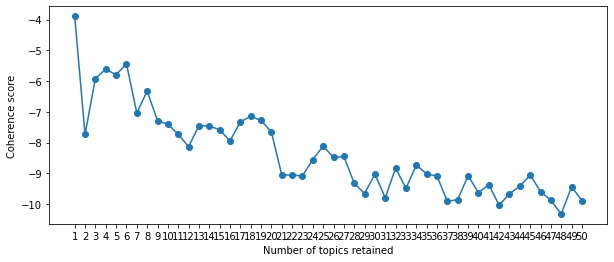

In [26]:
# set the random seed to make the results reproducible
np.random.seed(0)

# 我們相信這些文檔足夠乾淨，可以訓練主題建模。
# 使用 Tomotopy，有必要將預處理的文檔包裝在語料庫類對像中，
# 該對象必須被初始化（步驟 1）和填充（步驟 2）。
corpus = tp.utils.Corpus()                   # step 1 
for item in docs_phrased:                    # step 2 這邊輸入我們的文檔
    corpus.add_doc(words=item)

# 題建模過程的一個組成部分是探索替代模型的擬合，即保留不同數量主題的模型。
# 在此示例中，模型根據“u_ma​​ss”版本根據 Coherence Score 指標進行評估（分數越低，模型擬合越好）。
# 在第 1 步中，我們創建一個空字典來存儲不同模型的分數。
# 在第 2 步中，我們讓保留主題的數量在模型之間發生變化，並且對於每個模型，我們記錄相關的 Coherence Score
cvs = {}                                    # step 1
for topic_number in range(1, 51, 1):        # step 2
    mdl = tp.LDAModel(k=topic_number, corpus=corpus) # 這邊輸入我們的文檔
    for i in range(0, 100, 10): # 100 次迭代
        mdl.train(10)
        # print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
    coh = tp.coherence.Coherence(mdl, coherence="u_mass")
    cvs[topic_number] = coh.get_score() # 分數越低，模型擬合越好

# coherence of the results how to fix???????

# 這邊把csv視覺話 找最低分的
# The below chart displays the fit of the fifteen competing models, 
# retaining between one and fifteen topics.
# 下面的圖表顯示了 15 個競爭模型的擬合，保留 1 到 15 個主題。
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.plot(cvs.keys(), cvs.values(), "o-")
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(range(1, 51, 1))
plt.show()

# 圖表的可視檢查表示最佳模型是有 11 個主題的模型。
# 然而，為了提供更好的選擇，應該考慮更多的模型（例如在 1 到 200 主題的模型）。

In [27]:
# choose the topic for 48
# Hence, we train our best fit model.
best_mdl = tp.LDAModel(k=48, corpus=corpus)
for i in range(0, 100, 10):
    best_mdl.train(10)
    # print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))
# Using the ‘get_topic_words’ attribute, 
# we retrieve the topic-to-word probabilities, 
# a key outcome of topic modeling. The estimated probabilities are arranged into a Pandas DF.
# 使用“get_topic_words”屬性，我們可以取得主題到詞彙概率的預測，這是主題建模的一個重要結果。
wt = pd.DataFrame()
for k in range(best_mdl.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt = pd.concat([wt, tmp], ignore_index=False)
    del tmp
wt

/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,word,prob,k,sort
0,investment,0.095,0,0
1,return,0.078,0,1
2,investments,0.047,0,2
3,development,0.031,0,3
4,portfolio,0.029,0,4
...,...,...,...,...
5,rates,0.029,47,5
6,time,0.027,47,6
7,higher,0.019,47,7
8,basis,0.018,47,8


In [28]:
# The second outcome of topic modeling we retrieve consists of the topic-to-document probabilities,
#  which we retrieve using the ‘get_topic_dist’ attribute, 
# available for any document included in the LDA corpus used for the training.
# 第二個主題建模的結果是主題到文件概率的預測，
# 這可以使用“get_topic_dist”屬性，可用於訓練 LDA 的資料庫中包含的任何文件。
td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)
td #.head(1).T

/Users/user/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_39,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48
0,0.005320,0.005255,0.004506,0.007742,0.013132,0.005806,0.004379,0.005978,0.004571,0.003372,...,0.005793,0.006701,0.006324,0.004154,0.574014,0.008737,0.008813,0.006147,0.005106,0.005672
1,0.007433,0.007342,0.006296,0.010817,0.018347,0.008112,0.006118,0.008352,0.006386,0.004712,...,0.008094,0.009363,0.008836,0.005804,0.404827,0.012207,0.012314,0.008588,0.007133,0.007925
2,0.002871,0.002836,0.002432,0.004179,0.007087,0.003134,0.002363,0.003226,0.002467,0.001820,...,0.003127,0.003617,0.003413,0.002242,0.002960,0.004716,0.004757,0.003318,0.002756,0.003061
3,0.012330,0.012179,0.010444,0.017944,0.030435,0.013456,0.010148,0.343269,0.010593,0.007816,...,0.013426,0.015531,0.014657,0.009628,0.012710,0.020250,0.020427,0.014246,0.011833,0.013145
4,0.007433,0.007342,0.006296,0.010817,0.018347,0.008112,0.006118,0.008352,0.006386,0.004712,...,0.008094,0.009363,0.008836,0.005804,0.603409,0.012207,0.012314,0.008588,0.007133,0.007925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25171,0.006201,0.006126,0.005253,0.009025,0.180988,0.006768,0.005104,0.006968,0.005328,0.003931,...,0.006753,0.007812,0.007372,0.004843,0.006393,0.010185,0.010274,0.007165,0.005951,0.006612
25172,0.004658,0.004601,0.003945,0.006779,0.011497,0.005083,0.003834,0.005234,0.128447,0.002953,...,0.005072,0.005867,0.005537,0.003637,0.004802,0.007650,0.007717,0.005382,0.004470,0.004966
25173,0.005320,0.005255,0.004506,0.007742,0.013132,0.005806,0.004379,0.005978,0.004571,0.003372,...,0.005793,0.006701,0.006324,0.004154,0.005484,0.008737,0.008813,0.006147,0.005106,0.005672
25174,0.004658,0.004601,0.003945,0.131223,0.011497,0.005083,0.003834,0.005234,0.004002,0.002953,...,0.005072,0.130312,0.005537,0.003637,0.004802,0.007650,0.007717,0.005382,0.004470,0.004966


In [3]:
# model_df['tokens'] = clean_text['tokens']
# # concat the td tp model_df
# model_df = pd.concat([model_df, td], axis=1)

# # save the model_df and wt
# model_df.to_csv('model_df.csv', index=False)
# wt.to_csv('wt.csv', index=False)

# read the csv file 
model_df = pd.read_csv('model_df.csv')
wt = pd.read_csv('wt.csv')


In [4]:
model_df

,paragraph,participants,file_name,date,company_paticipants_yes,other_paticipants_yes,company_name,sentiment_score,tokens,topic_1,...,topic_39,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48
0,"Good morning, ladies and gentlemen. I welcome ...",Operator,20211104_Hannover_Rueck_SE-_Earnings_Call_2021...,2021-11-04,1,1,Hannover Rueck,1.000000,"['good', 'morning', 'ladies', 'gentlemen', 'to...",0.005320,...,0.005793,0.006701,0.006324,0.004154,0.574014,0.008737,0.008813,0.006147,0.005106,0.005672
1,Conference Call on the Q3 2021 Financial Resul...,Operator,20211104_Hannover_Rueck_SE-_Earnings_Call_2021...,2021-11-04,1,1,Hannover Rueck,-1.000000,"['conference', 'financial', 'conference']",0.007433,...,0.008094,0.009363,0.008836,0.005804,0.404827,0.012207,0.012314,0.008588,0.007133,0.007925
2,"being recorded. At this time, I would like to ...",Operator,20211104_Hannover_Rueck_SE-_Earnings_Call_2021...,2021-11-04,1,1,Hannover Rueck,-0.814570,"['recorded', 'time', 'hand', 'host', 'today', ...",0.002871,...,0.003127,0.003617,0.003413,0.002242,0.002960,0.004716,0.004757,0.003318,0.002756,0.003061
3,Jean-Jacques Henchoz,Jean-Jacques Henchoz,20211104_Hannover_Rueck_SE-_Earnings_Call_2021...,2021-11-04,0,1,Hannover Rueck,-1.000000,"['jean', 'jacques', 'henchoz']",0.012330,...,0.013426,0.015531,0.014657,0.009628,0.012710,0.020250,0.020427,0.014246,0.011833,0.013145
4,"Well, good morning, everyone and welcome to ou...",Jean-Jacques Henchoz,20211104_Hannover_Rueck_SE-_Earnings_Call_2021...,2021-11-04,0,1,Hannover Rueck,1.000000,"['good', 'morning', 'conference', 'presenting']",0.007433,...,0.008094,0.009363,0.008836,0.005804,0.603409,0.012207,0.012314,0.008588,0.007133,0.007925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25614,"Our ordinary income, that's very pleasing. And...",Karl Steinle,20211014_Hannover_Rueck_SE-_Shareholder_Mtg_Ca...,2021-10-14,0,1,Hannover Rueck,1.000000,"['ordinary', 'income', 'pleasing', 'historical...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25615,portfolio has been very reliable in terms of p...,Karl Steinle,20211014_Hannover_Rueck_SE-_Shareholder_Mtg_Ca...,2021-10-14,0,1,Hannover Rueck,0.555556,"['portfolio', 'reliable', 'terms', 'producing'...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25616,"low interest rate environment, of course is ch...",Karl Steinle,20211014_Hannover_Rueck_SE-_Shareholder_Mtg_Ca...,2021-10-14,0,1,Hannover Rueck,0.857143,"['low', 'rate', 'environment', 'challenging', ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25617,"inflation risk side, again I think it's over -...",Karl Steinle,20211014_Hannover_Rueck_SE-_Shareholder_Mtg_Ca...,2021-10-14,0,1,Hannover Rueck,-1.000000,"['inflation', 'risk', 'mixed', 'basket', 'miti...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
